Measurements and data analysis on the QREF sample, without the addition of nitrogen

In [87]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
    
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

Time domain sampling: 2425


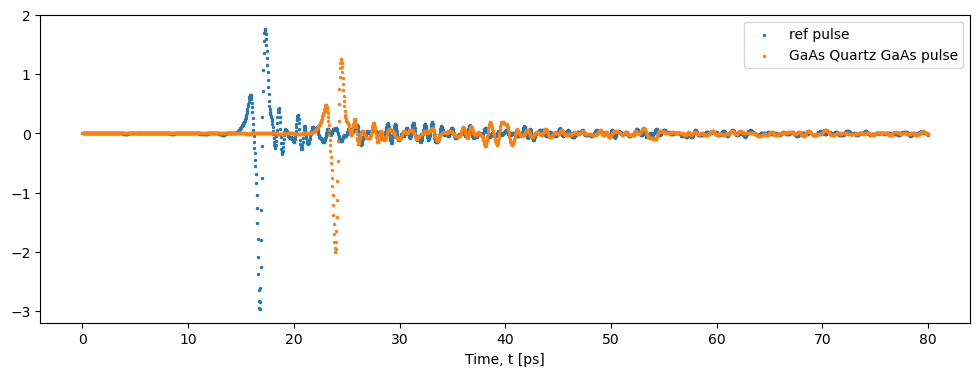

In [88]:
# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_04_02_2026\reference_pulse.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_HRZ_Si = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_04_02_2026\QREF_12.9um_air.txt",dtype=float)

t1= reference_pulse[:,0] + 740  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 = sample_pulse_HRZ_Si[:,0] + 740  # ADJUISTING THE AXIS
amp2 = sample_pulse_HRZ_Si[:,1]
time_axis_ref = t1
ref_pulse = amp1
time_axis_sample = t2
sample_pulse = amp2

#sample_pulse -= bias

## Known parameters
d = 380e-6

L = len(ref_pulse)
print(f'Time domain sampling: {L}')

# Structure: [GaAs-Quartz-GaAs]

plt.figure(figsize=(12,4))
plt.scatter(time_axis_ref, ref_pulse, label='ref pulse', s=2)
plt.scatter(time_axis_sample, sample_pulse, label='GaAs Quartz GaAs pulse', s=2)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [89]:
def compare_material_stacks(calculated, real):
    """
    Compare two material parameter stacks with separate real/imag errors for n.
    
    Args:
        calculated (list of tuples): [(n_complex, thickness_m), ...]
        real (list of tuples): [(n_complex, thickness_m), ...]
    
    Returns:
        list of dicts with abs and % errors for n_real, n_imag, and thickness.
    """
    results = []
    for i, ((n_calc, d_calc), (n_true, d_true)) in enumerate(zip(calculated, real), start=1):
        
        # Refractive index real part errors
        n_real_abs_err = abs(n_calc.real - n_true.real)
        n_real_pct_err = (n_real_abs_err / abs(n_true.real)) * 100 if n_true.real != 0 else float('inf')
        
        # Refractive index imaginary part errors
        n_imag_abs_err = abs(n_calc.imag - n_true.imag)
        n_imag_pct_err = (n_imag_abs_err / abs(n_true.imag)) * 100 if n_true.imag != 0 else float('inf')

        # Thickness errors
        d_abs_err = abs(d_calc - d_true)
        d_pct_err = (d_abs_err / abs(d_true)) * 100 if d_true != 0 else float('inf')

        results.append({
            "layer": i,
            "n_real_abs_err": n_real_abs_err,
            "n_real_pct_err": n_real_pct_err,
            "n_imag_abs_err": n_imag_abs_err,
            "n_imag_pct_err": n_imag_pct_err,
            "d_abs_err": d_abs_err,
            "d_pct_err": d_pct_err
        })
    
    return results

In [90]:
## Check time steps are consistent in t_axis
# Compute time differences between consecutive samples
dt = np.diff(time_axis_ref)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

deltat = np.mean(dt)
deltat = deltat * 1e-12  # Convert to seconds for calculations

Time steps are uniform: False
Min dt: 0.03300329999990481
Max dt: 0.033003309999912744
Mean dt: 0.033003300330033


Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.8, 2.4)
Layer 1 - k ∈ (-0.026000000000000002, -0.006)
Layer 1 - D ∈ (0.00098, 0.00102)
Layer 2 - D ∈ (-7.1000000000000015e-06, 3.29e-05)
Layer 3 - n ∈ (1.5999999999999999, 2.1999999999999997)
Layer 3 - k ∈ (-0.027000000000000003, -0.007000000000000001)
Layer 3 - D ∈ (0.00098, 0.00102)
Bayes params: [((2.2912283465244725-0.010123259547576133j), 0.0010076562996321034), ((1+0.001j), 1.0886517743938842e-05), ((1.8374040462820793-0.007000000000000001j), 0.0010173266847631095)]


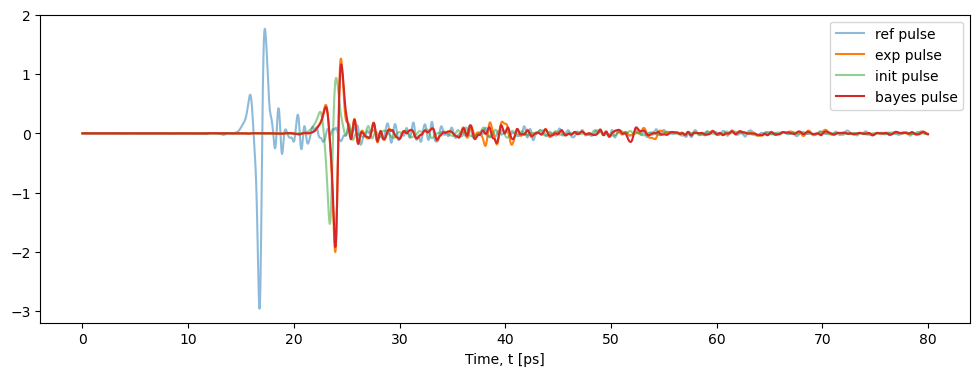

In [ ]:
# Initial guesses
n_Qa = 2.1
k_Qa= -0.016
d_Qa = 100e-5
n_air = 1.0
k_air = 0.001
d_air = 12.9* 1e-6
n_Qb = 1.9
k_Qb = -0.017
d_Qb = 100e-5

optimize_mask = [
    (True, True, True),  # Qa
    (False, False, True),  # air
    (True, True, True)  # Qb
]

init_guess = [
   
    ((n_Qa + 1j*k_Qa), d_Qa),  # Qa
    ((n_air + 1j*k_air), d_air),  # air
    ((n_Qb + 1j*k_Qb), d_Qb),  # Qb
]

optimization_bounds = [0.3,0.001,20e-06]

# Convert ref to torch tensor 
ref_pulse_t = torch.tensor(ref_pulse, dtype=torch.float32) 
sample_pulse_t = torch.tensor(sample_pulse, dtype=torch.float32) 

init_pulse = simulate_parallel(ref_pulse_t, init_guess, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

Bayes_model = BayesianLayeredExtractor(ref_pulse_t, sample_pulse_t, deltat=deltat, layers_init=init_guess, optimize_mask=optimize_mask, optimization_bounds=optimization_bounds)
bayes_params = Bayes_model.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(ref_pulse_t, bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params}')
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, init_pulse, label='init pulse', alpha = 0.5)
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 7 parameters for 600 iterations.
Iteration 49, Loss: 2.934081e-02, Layer 0: n=2.2899, k=0.00246, D=1015.70 µm | Layer 1: n=1.0000, k=0.00100, D=11.03 µm | Layer 2: n=1.8285, k=-0.01615, D=1014.45 µm
Iteration 99, Loss: 2.830323e-02, Layer 0: n=2.2809, k=0.00408, D=1018.93 µm | Layer 1: n=1.0000, k=0.00100, D=11.73 µm | Layer 2: n=1.8220, k=-0.01864, D=1026.32 µm
Iteration 149, Loss: 2.772160e-02, Layer 0: n=2.2694, k=0.00356, D=1024.05 µm | Layer 1: n=1.0000, k=0.00100, D=12.65 µm | Layer 2: n=1.8134, k=-0.01782, D=1043.36 µm
Iteration 199, Loss: 2.730010e-02, Layer 0: n=2.2585, k=0.00245, D=1029.10 µm | Layer 1: n=1.0000, k=0.00100, D=13.83 µm | Layer 2: n=1.8052, k=-0.01632, D=1059.58 µm
Iteration 249, Loss: 2.715571e-02, Layer 0: n=2.2516, k=0.00141, D=1032.41 µm | Layer 1: n=1.0000, k=0.00100, D=14.97 µm | Layer 2: n=1.8002, k=-0.01505, D=1069.58 µm
Iteration 299, Loss: 2.713248e-02, Layer 0: n=2.2484, k=0.00091, D=1033.98 µm | Layer 1: n=1.0000, k=0.00100, D=15.59 µm |

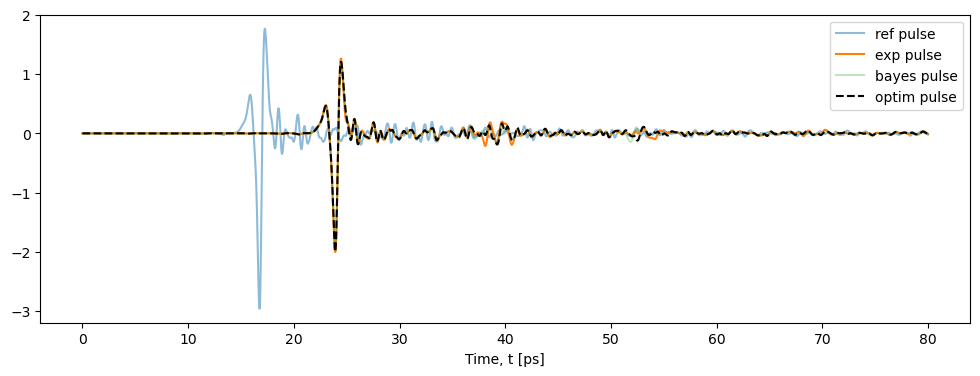

In [92]:
grad_optimizer = LayeredExtractor(ref_pulse_t, sample_pulse_t, deltat, bayes_params, optimize_mask, lr=0.01)
optim_params = grad_optimizer.optimize(num_iterations=600, updates=50, alpha=1)



optim_pulse = simulate_parallel(ref_pulse_t, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse', alpha = 0.3)
plt.plot(time_axis_sample, optim_pulse, label='optim pulse',linestyle='--' ,color='black' )
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [93]:
# Print initial guesses and optimized parameters
print('Initial guesses:')
for i, (n_d, d) in enumerate(init_guess):
    print(f"Layer {i+1}: n = {n_d.real:.4f} + {n_d.imag:.4f}j, d = {d*1e6:.2f} um")

print('\nOptimized parameters:')
for i, (n_d, d) in enumerate(optim_params):
    print(f"Layer {i+1}: n = {n_d.real:.4f} + {n_d.imag:.4f}j, d = {d*1e6:.2f} um")

Initial guesses:
Layer 1: n = 2.1000 + -0.0160j, d = 1000.00 um
Layer 2: n = 1.0000 + 0.0010j, d = 12.90 um
Layer 3: n = 1.9000 + -0.0170j, d = 1000.00 um

Optimized parameters:
Layer 1: n = 2.2436 + 0.0008j, d = 1036.37 um
Layer 2: n = 1.0000 + 0.0010j, d = 15.84 um
Layer 3: n = 1.8007 + -0.0144j, d = 1072.94 um


In [94]:
print("NaNs in bayes_params:", any(np.isnan(x[0].real) or np.isnan(x[0].imag) or np.isnan(x[1]) for x in bayes_params))
print("NaNs in optim_params:", any(np.isnan(x[0].real) or np.isnan(x[0].imag) or np.isnan(x[1]) for x in optim_params))
print("NaNs in optim_pulse:", np.isnan(optim_pulse).any())

NaNs in bayes_params: False
NaNs in optim_params: False
NaNs in optim_pulse: False
